<a href="https://colab.research.google.com/github/ShawwaHu/APPG/blob/main/Chunks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eulerian Video Magnification

<p>Eulerian video magnification reveals temporal variations in videos that are difficult or impossible to see with the naked eye and display them in an indicative manner.
</p>
<p>We are going to create a system which takes in an input video and outputs a video that is motion magnified. The system first decomposes the input video sequence into different
spatial frequency bands, and applies the same temporal filter to all bands. The filtered spatial bands are then amplified by a given factor $\alpha$,
added back to the original signal, and collapsed to generate the output video.</p>


The Algorithm we use is derived from MIT CSAIL's paper, ["Eulerian Video Magnification for Revealing Subtle Changes in the World"](http://people.csail.mit.edu/mrub/papers/vidmag.pdf). I have implemented their paper using Python.


##Overview of the Eulerian video magnification framework


![](https://github.com/joeljose/assets/blob/master/EVM/EVM_flow.png?raw=True)



##There are 5 steps in the algorithm pipeline:
1) Loading the video</br>
2) Spatial decomposition into laplacian pyramids</br>
3) Temporal filtering to extract motion information, and adding that back to the original signal</br>
4) Reconstruction </br>
5) Saving to output video</br>
We will first create helper functions for each of these steps. And finally put them altogether to get our motion magnification method.


In [ ]:
pip install --upgrade mediapipe opencv-python


  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [1]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


## Importing all the essential modules:

In [2]:
import os
import cv2
import numpy as np
import json
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot
import requests


In [3]:
import mediapipe as mp

## helper functions for loading and saving videos:

In [4]:

def uint8_to_float(data):
  """
  converts numpy array of type "uint8"(default type when we load through opencv)
  to "float" datatype.
  """
  result = np.ndarray(shape=data.shape, dtype='float')
  result[:] = data * (1. / 255)
  return result


def float_to_uint8(data):
  """
  converts numpy array of type "float" to "uint8" datatype.
  """
  result = np.ndarray(shape=data.shape, dtype='uint8')
  result[:] = data * 255
  return result



def load_video(video_filename):
    """Load a video into a numpy array"""
    video_filename = str(video_filename)
    print("Loading " + video_filename)
    if not os.path.isfile(video_filename):
        raise Exception("File Not Found: %s" % video_filename)
    capture = cv2.VideoCapture(video_filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = get_capture_dimensions(capture)
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    x = 0
    vid_frames = np.zeros((frame_count, height, width, 3), dtype='uint8')
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break

        vid_frames[x] = frame
        x += 1
    capture.release()

    return vid_frames, fps


def load_video_float(video_filename):
    """ Returns video as a numpy array of data type float"""
    vid_data, fps = load_video(video_filename)
    return uint8_to_float(vid_data), fps


def get_capture_dimensions(capture):
    """Get the dimensions of a capture"""
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def save_video(video, fps, save_filename='output.avi'):
    """Save a video to disk"""
    video = float_to_uint8(video)
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(save_filename, fourcc, fps, (video.shape[2], video.shape[1]), 1)
    for x in range(0, video.shape[0]):
        res = cv2.convertScaleAbs(video[x])
        writer.write(res)
    print('output saved to '+save_filename)


##Helper functions for Spatial Decomposition(Laplacian pyramids), Temporal filtering, and Reconstruction

In [5]:
def create_gaussian_image_pyramid(image, pyramid_levels):
    """ Creates a gaussian image pyramid for the input image"""
    gauss_copy = np.ndarray(shape=image.shape, dtype="float")
    gauss_copy[:] = image
    img_pyramid = [gauss_copy]
    for pyramid_level in range(1, pyramid_levels):
        gauss_copy = cv2.pyrDown(gauss_copy)
        img_pyramid.append(gauss_copy)

    return img_pyramid


def create_laplacian_image_pyramid(image, pyramid_levels):
    """ Creates a laplacian image pyramid for the input image"""
    gauss_pyramid = create_gaussian_image_pyramid(image, pyramid_levels)
    laplacian_pyramid = []
    for i in range(pyramid_levels - 1):
        laplacian_pyramid.append((gauss_pyramid[i] - cv2.pyrUp(gauss_pyramid[i + 1])))

    laplacian_pyramid.append(gauss_pyramid[-1])
    return laplacian_pyramid


def create_laplacian_video_pyramid(video, pyramid_levels):
    """Creates a laplacian video pyramid for the input video"""
    vid_pyramid = []
    for frame_number, frame in enumerate(video):
        frame_pyramid = create_laplacian_image_pyramid(frame, pyramid_levels)

        for pyramid_level, pyramid_sub_frame in enumerate(frame_pyramid):
            if frame_number == 0:
                vid_pyramid.append(
                    np.zeros((video.shape[0], pyramid_sub_frame.shape[0], pyramid_sub_frame.shape[1], 3),
                                dtype="float"))

            vid_pyramid[pyramid_level][frame_number] = pyramid_sub_frame

    return vid_pyramid


def temporal_bandpass_filter(data, fps, freq_min=0.833, freq_max=1, axis=0, amplification_factor=1):
    """
     filters out the motion information and returns
     an amplified version of the motion information.
    """
    fft = scipy.fftpack.rfft(data, axis=axis)
    frequencies = scipy.fftpack.fftfreq(data.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0

    result = np.ndarray(shape=data.shape, dtype='float')
    result[:] = np.abs(scipy.fftpack.ifft(fft, axis=0))
    result *= amplification_factor
    return result


def collapse_laplacian_pyramid(image_pyramid):
    """returns the reconstructed image from the input laplacian pyramid"""
    img = image_pyramid.pop()
    while image_pyramid:
        img = cv2.pyrUp(img) + (image_pyramid.pop() - 0)

    return img


def collapse_laplacian_video_pyramid(pyramid):
    """returns the reconstructed video from the input laplacian video pyramid"""
    i = 0
    while True:
        try:
            img_pyramid = [vid[i] for vid in pyramid]
            pyramid[0][i] = collapse_laplacian_pyramid(img_pyramid)
            i += 1
        except IndexError:
            break
    return pyramid[0]

## Motion magnification function:
Inputs to this method are video data(in numpy array format), fps of the video, lower cutoff frequency, upper cutoff frequency, amplification factor, number of levels in the pyramid, number of levels in the top of the pyramid that we skip for filtering.</br>


In [6]:
def eulerian_magnification(vid_data, fps, freq_min, freq_max, amplification, pyramid_levels=4, skip_levels_at_top=1):
    """ Returns the motion magnified video"""
    print("creating video pyramid....")
    vid_pyramid = create_laplacian_video_pyramid(vid_data, pyramid_levels=pyramid_levels)
    for i, vid in enumerate(vid_pyramid):
        if i < skip_levels_at_top or i >= len(vid_pyramid) - 1:
            # ignore the top and bottom of the pyramid. One end has too much noise and the other end is the
            # gaussian representation
            continue

        bandpassed = temporal_bandpass_filter(vid, fps, freq_min=freq_min, freq_max=freq_max, amplification_factor=amplification)

        vid_pyramid[i] += bandpassed

    print("bandpass filtering "+str([freq_min,freq_max])+"Hz...")
    vid_data = collapse_laplacian_video_pyramid(vid_pyramid)
    print("reconstructing from pyramid...")
    print("Done")
    return vid_data

##Calibration

In [ ]:
def calibration_phase(video_segment, fps, freq_min=0.1, freq_max=0.5, amplification=50, pyramid_levels=4):
    magnified_segment = eulerian_magnification(
        video_segment, fps, freq_min, freq_max, amplification, pyramid_levels
    )

    # Compute temporal mean (heatmap generation)
    heatmap = np.mean(np.abs(magnified_segment), axis=0)
    heatmap_gray = cv2.cvtColor(heatmap.astype(np.float32), cv2.COLOR_BGR2GRAY)

    # Normalize the heatmap to [0, 255]
    heatmap_normalized = cv2.normalize(heatmap_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold the heatmap with adaptive thresholding for better accuracy
    thresh = cv2.adaptiveThreshold(
        heatmap_normalized, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, blockSize=15, C=-2
    )

    # Morphological operations to remove noise and enhance features
    kernel = np.ones((5, 5), np.uint8)
    thresh_clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours and keep significant ones only (to focus on breathing area)
    contours, _ = cv2.findContours(thresh_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

    if not significant_contours:
        raise ValueError("No significant breathing motion detected during calibration.")

    # Create bounding rectangle around significant breathing areas (abdominal/chest area)
    x, y, w, h = cv2.boundingRect(np.vstack(significant_contours))

    # Draw rectangle for visualization
    heatmap_visual = cv2.cvtColor(heatmap_normalized, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(heatmap_visual, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return (x, y, w, h), heatmap_visual


## Show Frequencies in the video
We have also created a helper function that calculates the mean intensity variation in the input frames of the video. This helps us to figure out the cutoff frequencies required for our video.

In [7]:
def show_frequencies(vid_data, fps, bounds=None):
    """Graph the average value of the video as well as the frequency strength"""
    averages = []

    if bounds:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, bounds[2]:bounds[3], bounds[0]:bounds[1], :].sum())
    else:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, :, :, :].sum())

    averages = averages - min(averages)

    charts_x = 1
    charts_y = 2
    pyplot.figure(figsize=(20, 10))
    pyplot.subplots_adjust(hspace=.7)

    pyplot.subplot(charts_y, charts_x, 1)
    pyplot.title("Pixel Average")
    pyplot.xlabel("Time")
    pyplot.ylabel("Brightness")
    pyplot.plot(averages)

    freqs = scipy.fftpack.fftfreq(len(averages), d=1.0 / fps)
    fft = abs(scipy.fftpack.fft(averages))
    idx = np.argsort(freqs)

    pyplot.subplot(charts_y, charts_x, 2)
    pyplot.title("FFT")
    pyplot.xlabel("Freq (Hz)")
    freqs = freqs[idx]
    fft = fft[idx]

    freqs = freqs[len(freqs) // 2 + 1:]
    fft = fft[len(fft) // 2 + 1:]
    pyplot.plot(freqs, abs(fft))

    pyplot.show()

## Downloading the input video to our notebook
To do a demo of our motion magnification algorithm we use a video which was used in the original paper. </br>
You can alternatively use you own video as input too. You will have to upload the video to the colab notebook, and rename the 'filename' variable as the name of your video.</br>
If you want to try your own video, comment the first line in the next code block and Uncomment the next line and enter your own filename.


In [ ]:
#filename = "video.mp4" # If you want to try your own video, comment this line
                      # and Uncomment the next line and enter your own filename

filename="nowindow.mp4"


##Chunks

In [ ]:
def load_roi_video_in_chunks(video_filename, chunk_size=300):
    cap = cv2.VideoCapture(video_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames_with_roi = []

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.6)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            landmarks = result.pose_landmarks.landmark
            h, w = frame.shape[:2]

            left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]

            x_center = int(left_hip.x * w)
            y_top = int(left_hip.y * h)
            y_bottom = int(left_knee.y * h)

            # Adjust width to be narrow and centered on abdomen
            roi_width = int(w * 0.2)
            padding_y = int(h * 0.02)

            x_min = max(0, x_center - roi_width // 2)
            x_max = min(w, x_center + roi_width // 2)
            y_min = max(0, y_top - padding_y)
            y_max = min(h, y_bottom + padding_y)

            # Draw rectangle on full frame
           # cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Convert full frame with overlay to float and store
            #frame_float = uint8_to_float(frame)
            #frames_with_roi.append(frame_float)
            safe_width, safe_height = 640, 360  # both divisible by 16
            frame_resized = cv2.resize(frame, (safe_width, safe_height))

            frame_float = uint8_to_float(frame_resized)
            frames_with_roi.append(frame_float)

            if len(frames_with_roi) == chunk_size:
                yield np.array(frames_with_roi), fps
                frames_with_roi = []

    if frames_with_roi:
        yield np.array(frames_with_roi), fps

    cap.release()


In [ ]:
lower_hertz = 1.7
upper_hertz = 2
amplification_factor = 28
pyramid_levels = 4

In [ ]:
chunk_index = 0

# Construct a consistent filename prefix
chunk_prefix = filename.split(".")[0] + f"_levels_{pyramid_levels}_min_{lower_hertz}_max_{upper_hertz}_amp_{amplification_factor}"

for roi_chunk, fps in load_roi_video_in_chunks(filename, chunk_size=300):
    print(f"🔬 Processing ROI chunk {chunk_index + 1}")

    mag_chunk = eulerian_magnification(
        roi_chunk, fps,
        freq_min=lower_hertz,
        freq_max=upper_hertz,
        amplification=amplification_factor,
        pyramid_levels=pyramid_levels
    )

    # Save with consistent naming
    chunk_name = f"{chunk_prefix}_chunk_{chunk_index}.avi"
    save_video(mag_chunk, fps, chunk_name)

    # Cleanup
    del roi_chunk, mag_chunk
    import gc; gc.collect()

    chunk_index += 1


🔬 Processing ROI chunk 1
creating video pyramid....
bandpass filtering [1.7, 2]Hz...
reconstructing from pyramid...
Done
output saved to nowindow_levels_4_min_1.7_max_2_amp_28_chunk_0.avi
🔬 Processing ROI chunk 2
creating video pyramid....
bandpass filtering [1.7, 2]Hz...
reconstructing from pyramid...
Done
output saved to nowindow_levels_4_min_1.7_max_2_amp_28_chunk_1.avi
🔬 Processing ROI chunk 3
creating video pyramid....
bandpass filtering [1.7, 2]Hz...
reconstructing from pyramid...
Done
output saved to nowindow_levels_4_min_1.7_max_2_amp_28_chunk_2.avi
🔬 Processing ROI chunk 4
creating video pyramid....
bandpass filtering [1.7, 2]Hz...
reconstructing from pyramid...
Done
output saved to nowindow_levels_4_min_1.7_max_2_amp_28_chunk_3.avi


In [ ]:
chunk_prefix = filename.split(".")[0] + f"_levels_{pyramid_levels}_min_{lower_hertz}_max_{upper_hertz}_amp_{amplification_factor}"

with open("chunks.txt", "w") as f:
    for i in range(chunk_index):
        f.write(f"file '{chunk_prefix}_chunk_{i}.avi'\n")


In [ ]:
final_output_name = f"{chunk_prefix}_final_output.avi"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!ffmpeg -f concat -safe 0 -i chunks.txt -c copy "{final_output_name}"

##helper function for downloading video
You can skip the downloading part in this notebook if you are using your own video.

In [ ]:
def download_file(url, dest_filename):
    """Downloads the file in given url"""
    if os.path.isfile(dest_filename):
        print('Already Downloaded: %s to %s' % (url, dest_filename))
        return
    print('Downloading: %s to %s' % (url, dest_filename))

    response = requests.get(url, stream=True)
    if not response.ok:
        raise Exception("Couldn't download file")

    with open(dest_filename, 'wb') as fp:
        for block in response.iter_content(1024):
            fp.write(block)

## Downloading....
Skip the next code block if you are using your own video.

In [ ]:
download_file('http://people.csail.mit.edu/mrub/evm/video/face.mp4',filename)

Downloading: http://people.csail.mit.edu/mrub/evm/video/face.mp4 to video.mp4


## Final Demo on "input.mp4"
load the video and use show_frequencies to see the frequency range of the input video.

##HeatMap Spot Detection

## Extracting ROI

In [ ]:
def load_video_with_roi(video_filename):
    cap = cv2.VideoCapture(video_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames_roi = []

    # Initialize mediapipe once outside the loop
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.6)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            landmarks = result.pose_landmarks.landmark
            h, w = frame.shape[:2]

            # Use side landmarks for better coverage in side view
            left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]

            x_shoulder = int(left_shoulder.x * w)
            x_hip = int(left_hip.x * w)
            x_center = int((x_shoulder + x_hip) / 2)

            y_top = int(left_shoulder.y * h)
            y_bottom = int(left_knee.y * h)

            # Add padding
            padding_x = int(w * 0.1)
            padding_y = int(h * 0.05)

            x_min = max(0, x_center - padding_x)
            x_max = min(w, x_center + padding_x)
            y_min = max(0, y_top - padding_y)
            y_max = min(h, y_bottom + padding_y)

            roi = frame[y_min:y_max, x_min:x_max]
            roi_resized = cv2.resize(roi, (frame.shape[1], frame.shape[0]))
            roi_float = uint8_to_float(roi_resized)

            frames_roi.append(roi_float)

    cap.release()
    vid_data = np.array(frames_roi)
    return vid_data, fps


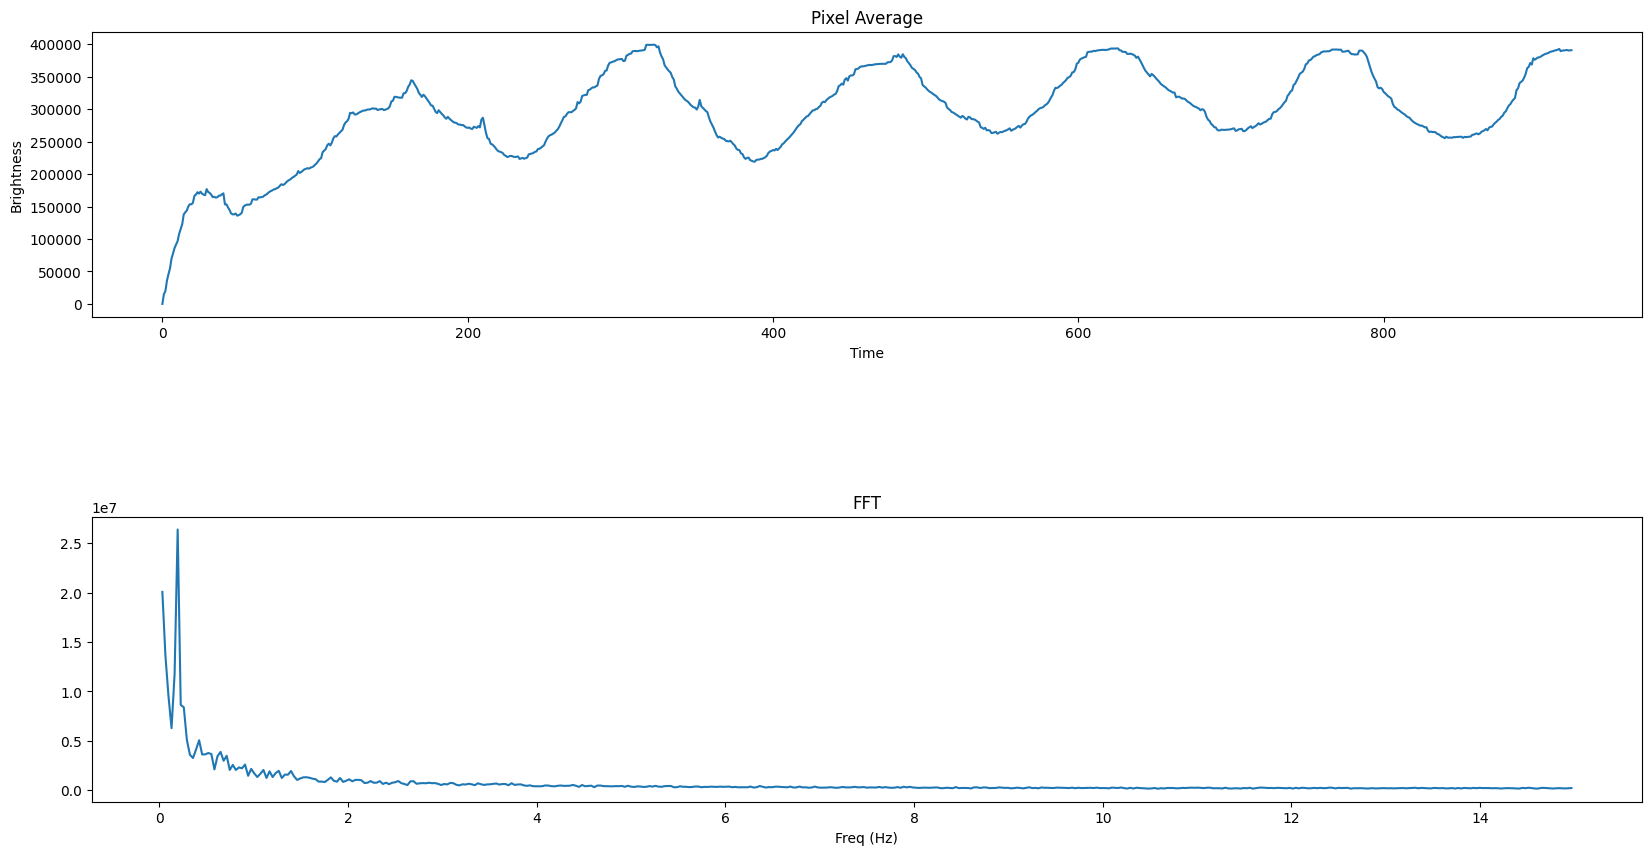

In [ ]:
vid, fps = load_video_with_roi(filename)
show_frequencies(vid, fps)

You can use this information for making changes in the cutoff frequencies in the next code block if you want to.

In [ ]:
lower_hertz = 0.5
upper_hertz = 2
amplification_factor = 50
pyramid_levels = 4

Motion magnify the loaded video:

In [ ]:
mag_vid = eulerian_magnification(
    vid, fps,
    freq_min=lower_hertz,
    freq_max=upper_hertz,
    amplification=amplification_factor,
    pyramid_levels=pyramid_levels
)

creating video pyramid....


save video to disk.

In [ ]:
out_name = filename.split(".")[0] + "_levels_" + str(pyramid_levels) + "_min_" + str(
    lower_hertz) + "_max_" + str(upper_hertz) + "_amp_" + str(amplification_factor)+'.avi'

save_video(mag_vid, fps, out_name)

output saved to me1_levels_4_min_0.5_max_2_amp_50.avi


##Conclusion
To amplify motion, EVM does not perform feature
tracking or optical flow computation, but merely magnifies temporal color changes using spatio-temporal processing. This Eulerian based method, which temporally processes pixels in a fixed spatial
region, successfully reveals informative signals and amplifies small motions in real-world videos.

One drawback of this method is that we can see that we get artifacts in our videos as we increase amplification factor.

In [ ]:
def detect_abdominal_roi(magnified_video, threshold_ratio=0.75, min_area=500, vertical_limit_ratio=0.5, horizontal_margin_ratio=0.2):
    height, width = magnified_video.shape[1:3]

    # Generate heatmap from magnified ROI video
    heatmap = np.mean(np.abs(magnified_video), axis=0)
    heatmap_gray = cv2.cvtColor(heatmap.astype(np.float32), cv2.COLOR_BGR2GRAY)
    heatmap_norm = cv2.normalize(heatmap_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold to isolate strongest movements
    threshold_val = np.percentile(heatmap_norm, threshold_ratio * 100)
    _, thresh = cv2.threshold(heatmap_norm, threshold_val, 255, cv2.THRESH_BINARY)

    # Morphological operations to clean noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    thresh_clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Detect contours
    contours, _ = cv2.findContours(thresh_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours clearly based on area and position (only mid-lower abdomen)
    vertical_limit = int(height * vertical_limit_ratio)
    horizontal_margin = int(width * horizontal_margin_ratio)

    selected_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= min_area:
            # Calculate centroid to check contour position clearly
            M = cv2.moments(cnt)
            if M["m00"] == 0: continue
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            if cY > vertical_limit and horizontal_margin < cX < (width - horizontal_margin):
                selected_contours.append((cnt, area, (cX, cY)))

    if not selected_contours:
        raise ValueError("No relevant abdominal contours detected.")

    # Clearly select the largest contour as the breathing ROI
    largest_contour = max(selected_contours, key=lambda x: x[1])[0]

    # Visualization
    contour_visualization = cv2.cvtColor(heatmap_norm, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_visualization, [largest_contour], -1, (0, 255, 0), 2)

    return largest_contour, contour_visualization

In [ ]:
spots, abdominal_heatmap_img = detect_abdominal_roi(
    mag_vid,
    threshold_ratio=0.75,
    min_area=100,
    vertical_limit_ratio=0.5,        # Ignores upper half
    horizontal_margin_ratio=0.2      # Ignores edges on left/right
)

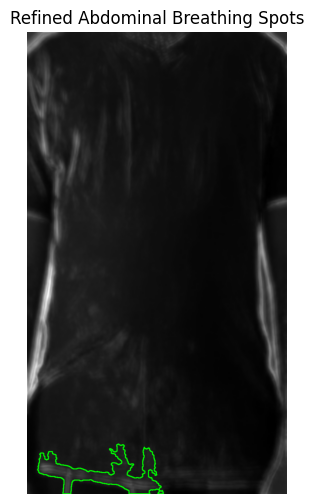

In [ ]:
# Visualize final refined detection
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(abdominal_heatmap_img, cv2.COLOR_BGR2RGB))
plt.title("Refined Abdominal Breathing Spots")
plt.axis('off')
plt.show()

##nitialization & Tracking Functions

In [ ]:
def initialize_tracking_points_contour(frame, contour, max_corners=20):
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)

    gray_frame = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(
        gray_frame, mask=mask, maxCorners=max_corners, qualityLevel=0.01, minDistance=3
    )

    return corners.reshape(-1, 1, 2)



def track_points_pca(magnified_video, initial_points):
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    tracked_points = []
    breathing_signal = []

    prev_gray = cv2.cvtColor((magnified_video[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    p0 = initial_points

    for frame in magnified_video[1:]:
        gray = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        p1, st, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, p0, None, **lk_params)

        # Discard points immediately if lost
        if p1 is None or len(p1[st==1]) == 0:
            break  # Exit if no points left

        good_new = p1[st==1]
        good_old = p0[st==1]

        motion_vectors = good_new - good_old

        # PCA to clearly identify main breathing direction
        if len(motion_vectors) >= 2:
            _, eigenvectors = cv2.PCACompute(motion_vectors, mean=None)
            primary_motion_dir = eigenvectors[0]
            projected_motion = np.dot(motion_vectors, primary_motion_dir)
            mean_motion = np.mean(projected_motion)
        else:
            mean_motion = 0

        breathing_signal.append(mean_motion)
        tracked_points.append(good_new)

        prev_gray = gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    return tracked_points, breathing_signal


##Execute Tracking & Generate Breathing Signal

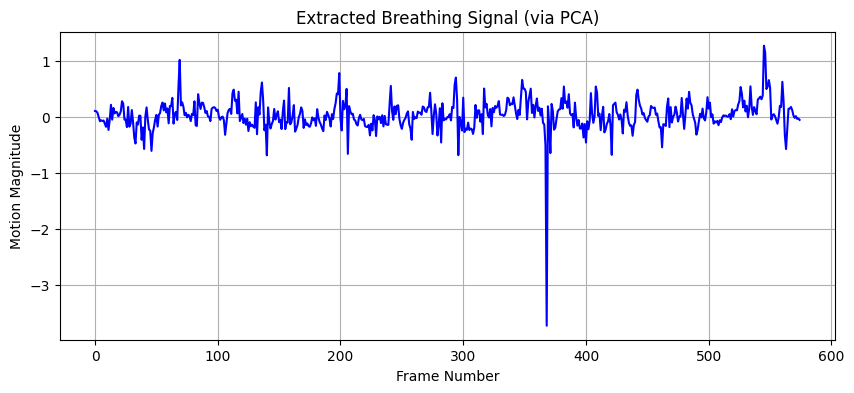

In [ ]:
# Initialize clearly
initial_frame = mag_vid[0]
initial_points = initialize_tracking_points_contour(initial_frame, spots)

# Perform tracking and PCA-based breathing signal extraction
tracked_points, breathing_signal = track_points_pca(mag_vid, initial_points)

# Display a clear plot of the extracted breathing signal
pyplot.figure(figsize=(10,4))
pyplot.plot(breathing_signal, color='blue')
pyplot.title('Extracted Breathing Signal (via PCA)')
pyplot.xlabel('Frame Number')
pyplot.ylabel('Motion Magnitude')
pyplot.grid(True)
pyplot.show()


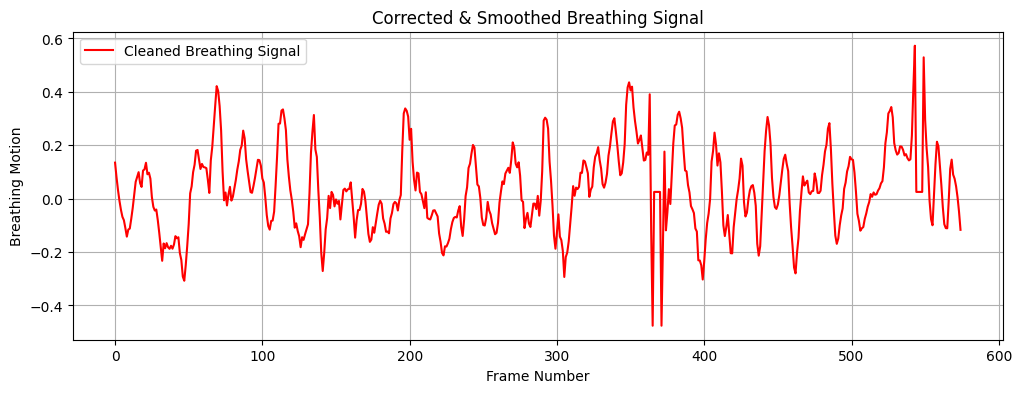

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Convert breathing signal to numpy array
breathing_signal_array = np.array(breathing_signal)

# Apply Savitzky-Golay filter for smoothing (window size 11, polynomial order 2)
smoothed_signal = signal.savgol_filter(breathing_signal_array, window_length=11, polyorder=2)

# Detect and remove outliers (statistical method)
median = np.median(smoothed_signal)
std_dev = np.std(smoothed_signal)
outlier_threshold = 3 * std_dev  # Points beyond this are considered outliers

# Replace outliers with median value
filtered_signal = np.where(
    np.abs(smoothed_signal - median) > outlier_threshold,
    median,
    smoothed_signal
)

# Plot the cleaned breathing signal
plt.figure(figsize=(12, 4))
plt.plot(filtered_signal, color='red', label='Cleaned Breathing Signal')
plt.title('Corrected & Smoothed Breathing Signal')
plt.xlabel('Frame Number')
plt.ylabel('Breathing Motion')
plt.legend()
plt.grid(True)
plt.show()
